# Final Capstone Project - Battle of Neighborhoods- 

Submission by Hupfstrudel

***Import necessary libraries***

In [1]:
import pandas as pd
import numpy as np
import pickle
import requests
import urllib
import json
import csv

import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
from folium import plugins

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

# Step 1. Obaining the Data

***1.1 Borough Data and Neighborhood Data***

I utilized the data from the NY Spatial Data Repository. The link to the free data is: https://geo.nyu.edu/catalog/nyu_2451_34572. For convinience I donloaded the data and am opening is as json before converting it into a pandas dataframe.

In [2]:
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Only the features key data is relevant for our analyis, so let's drop the rest...

In [4]:
newyork_data = newyork_data['features']

... and transfrom into a dataframe

In [5]:
neighborhoods = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'] )

In [6]:
for data in newyork_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Now we can utilize the geopy package to find the geographical ccordinates of New York City and use folium to create a map of our first dataframe. 

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [10]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

***1.2 Income and Population Data***

In [11]:
url = requests.get("https://en.wikipedia.org/wiki/Demographics_of_New_York_City")
soup = BeautifulSoup(url.content,'lxml')
table = soup.find_all('table')[0]
demo_temp = pd.read_html(str(table))[0]
demo_temp.head()

New York City's five boroughsvte                                \
                      Jurisdiction                    Population   
                           Borough    County Estimate (2019)[12]   
0                        The Bronx     Bronx             1418207   
1                         Brooklyn     Kings             2559903   
2                        Manhattan  New York             1628706   
3                           Queens    Queens             2253858   
4                    Staten Island  Richmond              476143   

                                                                \
  Gross Domestic Product                    Land area            
       billions(US$)[13] per capita(US$) square miles squarekm   
0                 42.695           30100        42.10   109.04   
1                 91.559           35800        70.82   183.42   
2                600.244          368500        22.83    59.13   
3                 93.310           41400       108.53   281.09   
4                 14.514           30500        58.37   151.18   

                                 
           Density               
  persons / sq. mi persons /km2  
0            33867        13006  
1            36147        13957  
2            71341        27544  
3            20767         8018  
4             8157         3150

And transfrom into a pandas dataframe.

In [12]:
demograph = pd.DataFrame(columns=['Borough','Population Density','per capita GDP'])

demograph['Borough'] = demo_temp.iloc[0:5,0]
demograph['Population Density'] = demo_temp.iloc[0:5,8]
demograph['per capita GDP'] = demo_temp.iloc[0:5,4]
demograph.loc[0,'Borough'] = 'Bronx'
demograph['Population Density'] = demograph['Population Density'].astype('int')
demograph['per capita GDP'] = demograph['per capita GDP'].astype('int')
demograph['Borough'] = demograph['Borough'].astype('str')

demograph

,Borough,Population Density,per capita GDP
0,Bronx,13006,30100
1,Brooklyn,13957,35800
2,Manhattan,27544,368500
3,Queens,8018,41400
4,Staten Island,3150,30500


Write to csv for potential later use

In [13]:
demograph.to_csv('demograph.csv')

Now we can obtain GeoJSON data to visualize the demographics with a choropleth map

In [14]:
url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'
f = urllib.request.urlopen(url)
geo = json.load(f)

with open('Borough Boundaries.geojson','a') as outfile:
    json.dump(geo,outfile)

In [15]:
with open('Borough Boundaries.geojson') as data:
    newyork_geo = json.load(data)

JSONDecodeError: Extra data: line 1 column 3101384 (char 3101383)

In [16]:
points = [[[40.86,-73.90],[40.86,-73.83]],
          [[40.66,-73.98],[40.66,-73.89]],
          [[40.72,-74.00],[40.80,-73.94]],
          [[40.72,-73.82],[40.72,-73.74]],
          [[40.59,-74.19],[40.59,-74.07]]]
labels = ['BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND']

In [17]:
map_population = folium.Map(location=[latitude,longitude],zoom_start=11)

for point,label in zip(points,labels):
    line = folium.PolyLine(point,color='yellow',weight=2.5,opacity=0.1)
    attribute = {'fill':'black','font-weight':'bold','font-size':'18'}
    map_population.add_child(line)
    folium.plugins.PolyLineTextPath(line,label,repeat=False,offset=0,attributes=attribute).add_to(map_population)

In [18]:
map_population.choropleth(geo_data=newyork_geo, 
                       data=demograph, 
                       columns=['Borough','Population Density'],
                       key_on='properties.boro_name', 
                       fill_color='YlOrRd', 
                       fill_opacity=0.7, 
                       line_opacity=0.2, 
                       legend_name='Population Density in New York')

NameError: name 'newyork_geo' is not defined

In [19]:
map_population

In [20]:
map_income = folium.Map(location=[latitude,longitude],zoom_start=11)

for point,label in zip(points,labels):
    line = folium.PolyLine(point,color='yellow',weight=2.5,opacity=0.1)
    attribute = {'fill':'black','font-weight':'bold','font-size':'18'}
    map_income.add_child(line)
    folium.plugins.PolyLineTextPath(line,label,repeat=False,offset=0,attributes=attribute).add_to(map_income)

In [21]:
map_income.choropleth(geo_data=newyork_geo, 
                       data=demograph, 
                       columns=['Borough','per capita GDP'],
                       key_on='properties.boro_name', 
                       fill_color='YlOrRd', 
                       fill_opacity=0.7, 
                       line_opacity=0.2, 
                       legend_name='per capita Income in New York')

NameError: name 'newyork_geo' is not defined

In [22]:
map_income

# Step 2. Obtain Foursquare Data about Restaurants

In [23]:
CLIENT_ID = '' 
CLIENT_SECRET = '' 
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZYCMLX5WUBZZEOFKK1WRSVMJI1IMIVMQY0A5RITLWS3LHX10
CLIENT_SECRET:44VM5QL4K3BNVOT5TCOPLIL3YQBXDML1SE4ZVNSFLQANXHIH


***What is our category of interest?***

In [24]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [25]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [26]:
category_list = category_results['response']['categories']

In [27]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


We are interested to analyze restaurants, thus the FOOD + its subcategories is relevant for us.

In [28]:
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [29]:
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

In [30]:
category_dict

{'4d4b7105d754a06374d81259': 'Food',
 '503288ae91d4c4b30a586d67': 'Afghan Restaurant',
 '4bf58dd8d48988d1c8941735': 'African Restaurant',
 '4bf58dd8d48988d10a941735': 'Ethiopian Restaurant',
 '4bf58dd8d48988d14e941735': 'American Restaurant',
 '4bf58dd8d48988d157941735': 'New American Restaurant',
 '4bf58dd8d48988d142941735': 'Asian Restaurant',
 '56aa371be4b08b9a8d573568': 'Burmese Restaurant',
 '52e81612bcbc57f1066b7a03': 'Cambodian Restaurant',
 '4bf58dd8d48988d145941735': 'Chinese Restaurant',
 '52af3a5e3cf9994f4e043bea': 'Anhui Restaurant',
 '52af3a723cf9994f4e043bec': 'Beijing Restaurant',
 '52af3a7c3cf9994f4e043bed': 'Cantonese Restaurant',
 '58daa1558bbb0b01f18ec1d3': 'Cha Chaan Teng',
 '52af3a673cf9994f4e043beb': 'Chinese Aristocrat Restaurant',
 '52af3a903cf9994f4e043bee': 'Chinese Breakfast Place',
 '4bf58dd8d48988d1f5931735': 'Dim Sum Restaurant',
 '52af3a9f3cf9994f4e043bef': 'Dongbei Restaurant',
 '52af3aaa3cf9994f4e043bf0': 'Fujian Restaurant',
 '52af3ab53cf9994f4e043bf1'

Here we can see a list of all relevant categories and their id's

# Let us explore just the first neighborhood - Wakefield-

Just so that we can be more familiar with the request function 

In [19]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

In [20]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] 
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] 

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


**Top 10 venues within a radius of 500m in the category 'FOOD'**

In [21]:
LIMIT = 10 
radius = 500 
categoryId = '4d4b7105d754a06374d81259' 

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/search?&client_id=ZYCMLX5WUBZZEOFKK1WRSVMJI1IMIVMQY0A5RITLWS3LHX10&client_secret=44VM5QL4K3BNVOT5TCOPLIL3YQBXDML1SE4ZVNSFLQANXHIH&v=20180604&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=10'

In [22]:
results = requests.get(url).json()

***We can filter out only the relevant information for us***

In [23]:
venues=results['response']['venues']

In [24]:
wakefield_venues = pd.json_normalize(venues)
wakefield_venues.head(10)

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,4e440828a809d4ed1bb7059f,Pitman Deli,"[{'id': '4d4b7105d754a06374d81259', 'name': 'F...",v-1589753095,False,2020 Pitman Ave,DeReimer Ave,40.894149,-73.845748,"[{'label': 'display', 'lat': 40.89414920073695...",136,10466,US,Bronx,NY,United States,"[2020 Pitman Ave (DeReimer Ave), Bronx, NY 104..."
1,4c783cef3badb1f7e4244b54,Carvel Ice Cream,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",v-1589753095,False,1006 E 233rd St,NaN,40.890487,-73.848568,"[{'label': 'display', 'lat': 40.89048668575960...",483,10466,US,Bronx,NY,United States,"[1006 E 233rd St, Bronx, NY 10466, United States]"
2,55aa92ac498e24734cd2e378,Louis Pizza,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",v-1589753095,False,1840 Nereid Ave,Ely Ave,40.898399,-73.848810,"[{'label': 'display', 'lat': 40.898399, 'lng':...",432,10466,US,Bronx,NY,United States,"[1840 Nereid Ave (Ely Ave), Bronx, NY 10466, U..."
3,4e1627498877d38dc9037a11,New China Gardens,"[{'id': '4bf58dd8d48988d142941735', 'name': 'A...",v-1589753095,False,724 Nereid Ave,at E. 238th St.,40.897796,-73.853388,"[{'label': 'display', 'lat': 40.897796, 'lng':...",624,10466,US,Bronx,NY,United States,"[724 Nereid Ave (at E. 238th St.), Bronx, NY 1..."
4,4eb046abb8f7116f21081aeb,Baychester Avenue Food Truck,"[{'id': '4bf58dd8d48988d1cb941735', 'name': 'F...",v-1589753095,False,Baychester Avenue,233rd Street,40.890479,-73.842725,"[{'label': 'display', 'lat': 40.89047926874748...",602,10466,US,Bronx,NY,United States,"[Baychester Avenue (233rd Street), Bronx, NY 1..."
5,4f32458019836c91c7c734ff,Central Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",v-1589753095,False,2020 Pitman Ave,NaN,40.896728,-73.844387,"[{'label': 'display', 'lat': 40.896728, 'lng':...",326,10466,US,Bronx,NY,United States,"[2020 Pitman Ave, Bronx, NY 10466, United States]"
6,4d447ade7e2e548187df608f,Pastele Factory,"[{'id': '4bf58dd8d48988d150941735', 'name': 'S...",v-1589753095,False,NERD AVE,NaN,40.898787,-73.848338,"[{'label': 'display', 'lat': 40.89878722439789...",464,NaN,US,Bronx,NY,United States,"[NERD AVE, Bronx, NY, United States]"
7,4f32866319836c91c7e049ea,Deli LM,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",v-1589753095,False,1836 Nereid Ave,NaN,40.898373,-73.848908,"[{'label': 'display', 'lat': 40.898373, 'lng':...",432,10466,US,Bronx,NY,United States,"[1836 Nereid Ave, Bronx, NY 10466, United States]"


In [25]:
print('{} venues were returned by Foursquare.'.format(wakefield_venues.shape[0]))

8 venues were returned by Foursquare.


Now we can clean the data and remove unnecessary columns.

In [27]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
wakefield_venues =wakefield_venues.loc[:, filtered_columns]

wakefield_venues['categories'] = wakefield_venues.apply(get_category_type, axis=1)

wakefield_venues.columns = [col.split(".")[-1] for col in wakefield_venues.columns]

In [29]:
wakefield_venues

,name,categories,lat,lng
0,Pitman Deli,Food,40.894149,-73.845748
1,Carvel Ice Cream,Ice Cream Shop,40.890487,-73.848568
2,Louis Pizza,Pizza Place,40.898399,-73.848810
3,New China Gardens,Asian Restaurant,40.897796,-73.853388
4,Baychester Avenue Food Truck,Food Truck,40.890479,-73.842725
5,Central Deli,Deli / Bodega,40.896728,-73.844387
6,Pastele Factory,Spanish Restaurant,40.898787,-73.848338
7,Deli LM,Deli / Bodega,40.898373,-73.848908


This worked out perfectly. All 8 venues are food related.

***Write the dataframe to a csv for potential later use.***

In [37]:
wakefield_venues.to_csv('wakefield_venues.csv')

***Now let's retrieve the data for all the neighborhoods***

In [115]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

In [30]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259",
            LIMIT)
            
        try:
            results = requests.get(url).json()['response']['venues']
            
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [32]:
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


In [33]:
nyc_venues.shape

(13673, 7)

In [34]:
nyc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889322,-73.843323,Fried Chicken Joint
4,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant


***Let's write the dataframe to a csv for later use***

In [36]:
nyc_venues.to_csv('nyc_venues.csv')

# Step 3. Data Analysis

In [9]:
nyc_venues=pd.read_csv('nyc_venues.csv')

Let's take a closer look at our dataframe.

In [101]:
nyc_venues['Venue Category'].unique()

array(['Food', 'Ice Cream Shop', 'Caribbean Restaurant',
       'Fried Chicken Joint', 'Fast Food Restaurant', 'Bakery',
       'Pizza Place', 'Burger Joint', 'Coffee Shop', 'Juice Bar',
       'Comfort Food Restaurant', 'Deli / Bodega', 'Mexican Restaurant',
       'Food Truck', 'Donut Shop', 'Spanish Restaurant',
       'Chinese Restaurant', 'Bagel Shop', 'Sandwich Place',
       'American Restaurant', 'Italian Restaurant', 'BBQ Joint',
       'African Restaurant', 'Dessert Shop', 'Snack Place',
       'Dumpling Restaurant', 'Diner', 'Grocery Store', 'Wings Joint',
       'Asian Restaurant', 'Breakfast Spot', 'Seafood Restaurant', 'Café',
       'Latin American Restaurant', 'Sushi Restaurant', 'Steakhouse',
       'Bar', 'Tapas Restaurant', 'German Restaurant', 'Greek Restaurant',
       'Japanese Restaurant', 'Indian Restaurant',
       'Mediterranean Restaurant', 'Lounge', 'Pub', 'Fish & Chips Shop',
       'Restaurant', 'Empanada Restaurant', 'Cafeteria',
       'Salvadoran Restau

In [102]:
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Deli / Bodega                1410
Pizza Place                  1163
Coffee Shop                   802
Fast Food Restaurant          643
Chinese Restaurant            638
                             ... 
Japanese Curry Restaurant       1
Kebab Restaurant                1
Dive Bar                        1
Nightclub                       1
Bowling Alley                   1
Name: Venue Category, Length: 194, dtype: int64

We can see that we have 194 unique categories. This is way too much for ou purposes, so lets only include categories that include the term "restaurant"

In [103]:
nyc_restaurants=nyc_venues[nyc_venues['Venue Category'].str.contains('Restaurant')]

In [104]:
nyc_restaurants.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).head(40)

Venue Category
Fast Food Restaurant               643
Chinese Restaurant                 638
Italian Restaurant                 473
Mexican Restaurant                 374
Caribbean Restaurant               351
American Restaurant                315
Restaurant                         207
Sushi Restaurant                   163
Seafood Restaurant                 147
Latin American Restaurant          144
Japanese Restaurant                143
Asian Restaurant                   142
Spanish Restaurant                 130
Thai Restaurant                    106
Indian Restaurant                  104
Southern / Soul Food Restaurant     69
Korean Restaurant                   62
Greek Restaurant                    58
Middle Eastern Restaurant           56
Vegetarian / Vegan Restaurant       54
New American Restaurant             52
Ramen Restaurant                    39
French Restaurant                   39
Mediterranean Restaurant            38
Vietnamese Restaurant               38
Peruvian R

Now the list of unique categories is reduced to 88

Let us focus only on the top 10 types of ethnic restaurants and filter out everything else.

In [105]:
rest_type = [
    'Chinese Restaurant', 
    'Italian Restaurant', 
    'Mexican Restaurant', 
    'Caribbean Restaurant',
    'Sushi Restaurant',
    'Latin American Restaurant',
    'Japanese Restaurant',
    'Spanish Restaurant',
    'Thai Restaurant',
    'Indian Restaurant']

In [106]:
nyc_restaurants=nyc_restaurants[nyc_restaurants['Venue Category'].str.contains('|'.join(rest_type))]

In [107]:
nyc_restaurants = nyc_restaurants[~nyc_restaurants["Venue Category"].str.contains('North')]
nyc_restaurants = nyc_restaurants[~nyc_restaurants["Venue Category"].str.contains('Indian Chinese')]

In [108]:
nyc_restaurants.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

Venue Category
Chinese Restaurant           638
Italian Restaurant           473
Mexican Restaurant           374
Caribbean Restaurant         351
Sushi Restaurant             163
Latin American Restaurant    144
Japanese Restaurant          143
Spanish Restaurant           130
Thai Restaurant              106
Indian Restaurant            104
Name: Venue Category, dtype: int64

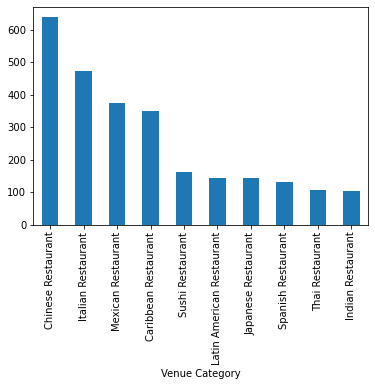

In [109]:
nyc_restaurants.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).plot(kind='bar')

In [110]:
print('There are {} uniques restaurants within the top 10 types.'.format(len(nyc_restaurants['Venue'].unique())))

There are 1424 uniques restaurants within the top 10 types.


In [111]:
nyc_restaurants.shape

(2626, 8)

In [112]:
nyc_restaurants.head(20)

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,2,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
10,10,Wakefield,40.894705,-73.847201,Jerk House,40.894728,-73.856846,Caribbean Restaurant
11,11,Wakefield,40.894705,-73.847201,Paul's Caribbean Bakery,40.899774,-73.857177,Caribbean Restaurant
16,16,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
18,18,Wakefield,40.894705,-73.847201,Ali's Roti,40.899720,-73.856673,Caribbean Restaurant
19,19,Wakefield,40.894705,-73.847201,Big Daddy's Caribbean Taste Restaurant,40.899767,-73.857135,Caribbean Restaurant
20,20,Wakefield,40.894705,-73.847201,Golden Fountain Restaurant,40.889042,-73.842313,Caribbean Restaurant
26,26,Wakefield,40.894705,-73.847201,El Gigante,40.891695,-73.859466,Mexican Restaurant
36,36,Wakefield,40.894705,-73.847201,Pastele Factory,40.898787,-73.848338,Spanish Restaurant
39,39,Wakefield,40.894705,-73.847201,Dragon Star Chinese Food,40.893952,-73.856779,Chinese Restaurant


In [116]:
nyc_restaurants.groupby('Neighborhood')['Neighborhood'].count().sort_values(ascending=False).head(50)

Neighborhood
Bay Terrace            25
Paerdegat Basin        22
Laurelton              21
Canarsie               20
South Ozone Park       20
Douglaston             19
Parkchester            18
Cambria Heights        17
Tottenville            17
Van Nest               16
North Corona           16
Jackson Heights        16
Erasmus                16
Rugby                  16
Wingate                15
Richmond Hill          15
Belmont                15
Fox Hills              15
Melrose                15
Sunnyside              15
Park Hill              14
St. Albans             14
Bellaire               14
Georgetown             14
Little Neck            14
Fresh Meadows          14
Hunters Point          14
Schuylerville          14
Queensboro Hill        14
Queens Village         14
Ditmas Park            14
Great Kills            14
Longwood               13
Morris Park            13
Shore Acres            13
New Dorp               13
Rockaway Park          13
Jamaica Estates        13

In [113]:
nyc_restaurants.to_csv('nyc_restaurants.csv')

# Step 4. First Decision on location

Manhatten is clearly a very cmpetitive and saturated market. Thus we choose Brooklyn with the second highest population density and third highest GDP in New York City as our preferred borough.

***Isolating neighborhoods***

In [34]:
nyc_restaurants=pd.read_csv('nyc_restaurants.csv')

In [35]:
brooklyn=neighborhoods[neighborhoods['Borough'].str.contains('Brooklyn')]
brooklyn_neighborhoods=brooklyn.Neighborhood.unique()
brooklyn_restaurants=nyc_restaurants[nyc_restaurants['Neighborhood'].str.contains('|'.join(brooklyn_neighborhoods))]
brooklyn_restaurants.shape

(575, 9)

In [36]:
queens=neighborhoods[neighborhoods['Borough'].str.contains('Queens')]
queens_neighborhoods=queens.Neighborhood.unique()

In [37]:
bronx=neighborhoods[neighborhoods['Borough'].str.contains('Bronx')]
bronx_neighborhoods=bronx.Neighborhood.unique()

In [38]:
manhattan=neighborhoods[neighborhoods['Borough'].str.contains('Manhattan')]
manhattan_neighborhoods=manhattan.Neighborhood.unique()

In [39]:
staten_island=neighborhoods[neighborhoods['Borough'].str.contains('Staten Island')]
staten_island_neighborhoods=staten_island.Neighborhood.unique()

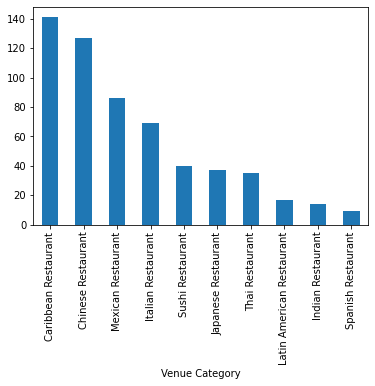

In [40]:
brooklyn_restaurants.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).plot(kind='bar')

We can see that most restaurants in Brooklyn are either Caribbean or Chinese. We will ignore those two markets and instead decide to open a Mexican restaurant. Since it is fairly popular, but not completeley saturated. Further more Hispanics make up about 27.5 percent of the population in New York City. So the potential demand and market ist quite large.

In [41]:
brooklyn_restaurants.head()

,Unnamed: 0,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
477,2112,2112,Bay Ridge,40.625801,-74.030621,Lobo Loco,40.623563,-74.031047,Mexican Restaurant
478,2131,2131,Bay Ridge,40.625801,-74.030621,Sakana Sushi & Asian Bistro,40.623623,-74.024910,Sushi Restaurant
479,2133,2133,Bay Ridge,40.625801,-74.030621,Tairyo Japanese Fusion,40.631792,-74.027477,Japanese Restaurant
480,2143,2143,Bay Ridge,40.625801,-74.030621,Chipotle Mexican Grill,40.622043,-74.026672,Mexican Restaurant
481,2144,2144,Bay Ridge,40.625801,-74.030621,Fushimi,40.617270,-74.031010,Japanese Restaurant


Let us create a map of all the restaurants in the borough brooklyn

In [42]:
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood, venue, in zip(brooklyn_restaurants['Venue Latitude'], brooklyn_restaurants['Venue Longitude'],brooklyn_restaurants['Neighborhood'], brooklyn_restaurants['Venue']):
    label = '{}, {}'.format(neighborhood, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

# Step 5. Analysis of restaurants in the borough Brooklyn

***One Hot Encoding***

In [43]:
brooklyn_onehot = pd.get_dummies(brooklyn_restaurants[['Venue Category']], prefix="", prefix_sep="")

In [44]:
brooklyn_onehot['Neighborhood'] = brooklyn_restaurants['Neighborhood'] 

In [45]:
Neighborhood = brooklyn_onehot['Neighborhood']

brooklyn_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
brooklyn_onehot.insert(0, 'Neighborhood', Neighborhood)

brooklyn_onehot.reset_index(inplace=True)

brooklyn_onehot.head(20)

,index,Neighborhood,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant
0,477,Bay Ridge,0,0,0,0,0,0,1,0,0,0
1,478,Bay Ridge,0,0,0,0,0,0,0,0,1,0
2,479,Bay Ridge,0,0,0,0,1,0,0,0,0,0
3,480,Bay Ridge,0,0,0,0,0,0,1,0,0,0
4,481,Bay Ridge,0,0,0,0,1,0,0,0,0,0
5,482,Bay Ridge,0,0,0,0,0,0,0,0,0,1
6,483,Bay Ridge,0,0,0,0,0,0,1,0,0,0
7,484,Bensonhurst,0,1,0,0,0,0,0,0,0,0
8,485,Bensonhurst,0,1,0,0,0,0,0,0,0,0
9,486,Bensonhurst,0,0,0,0,0,0,0,0,1,0


In [46]:
brooklyn_onehot=brooklyn_onehot.drop(['index'], axis=1)
brooklyn_onehot.head()

,Neighborhood,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant
0,Bay Ridge,0,0,0,0,0,0,1,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,1,0
2,Bay Ridge,0,0,0,0,1,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,1,0,0,0
4,Bay Ridge,0,0,0,0,1,0,0,0,0,0


***And again write to a csv for potential later use***

In [210]:
brooklyn_onehot.to_csv('brooklyn_onehot.csv')

In [47]:
brooklyn_onehot=pd.read_csv('brooklyn_onehot.csv')
brooklyn_onehot.head(0)

,Unnamed: 0,Neighborhood,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant


In [48]:
brooklyn_onehot=brooklyn_onehot.drop(['Unnamed: 0'], axis=1)
brooklyn_onehot.head(0)

,Neighborhood,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant


To simplify the overview, we can group our dataframe by neighborhood and show the mean of occurrence of each type of restaurant

In [49]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped.head(10)

,Neighborhood,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Sushi Restaurant,Thai Restaurant
0,Bath Beach,0.000000,0.714286,0.000,0.142857,0.000000,0.0,0.000000,0.000,0.142857,0.000000
1,Bay Ridge,0.000000,0.000000,0.000,0.000000,0.285714,0.0,0.428571,0.000,0.142857,0.142857
2,Bedford Stuyvesant,0.333333,0.000000,0.000,0.166667,0.166667,0.0,0.333333,0.000,0.000000,0.000000
3,Bensonhurst,0.000000,0.700000,0.000,0.100000,0.000000,0.0,0.000000,0.000,0.200000,0.000000
4,Bergen Beach,0.000000,0.200000,0.000,0.200000,0.200000,0.0,0.000000,0.000,0.400000,0.000000
5,Boerum Hill,0.000000,0.000000,0.000,0.000000,0.000000,0.0,1.000000,0.000,0.000000,0.000000
6,Brighton Beach,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000,1.000000,0.000000
7,Broadway Junction,0.250000,0.250000,0.125,0.000000,0.000000,0.0,0.250000,0.125,0.000000,0.000000
8,Brooklyn Heights,0.000000,0.000000,0.000,0.000000,0.000000,0.0,1.000000,0.000,0.000000,0.000000
9,Brownsville,0.500000,0.375000,0.000,0.000000,0.000000,0.0,0.000000,0.125,0.000000,0.000000


In [50]:
brooklyn_grouped.shape

(69, 11)

With this, let us isolate the top 5 restaurants per neighborhood in Brooklyn

In [51]:
def common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))   

In [53]:
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Neighborhood'] = brooklyn_grouped['Neighborhood']

In [54]:
for ind in np.arange(brooklyn_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bath Beach,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Spanish Restaurant
1,Bay Ridge,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant
2,Bedford Stuyvesant,Mexican Restaurant,Caribbean Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant
3,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Spanish Restaurant
4,Bergen Beach,Sushi Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant
5,Boerum Hill,Mexican Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Latin American Restaurant
6,Brighton Beach,Sushi Restaurant,Thai Restaurant,Spanish Restaurant,Mexican Restaurant,Latin American Restaurant
7,Broadway Junction,Mexican Restaurant,Chinese Restaurant,Caribbean Restaurant,Spanish Restaurant,Indian Restaurant
8,Brooklyn Heights,Mexican Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Latin American Restaurant
9,Brownsville,Caribbean Restaurant,Chinese Restaurant,Spanish Restaurant,Thai Restaurant,Sushi Restaurant


# Step 6. Clustering

In [55]:
brooklyn_grouped_clustering = brooklyn_grouped.drop('Neighborhood', 1)

Determine optimal amount of clusters

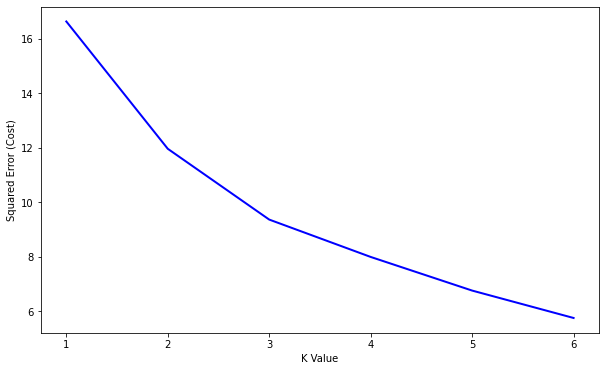

In [56]:
cost =[] 
for i in range(1, 7): 
    kmeans = KMeans(n_clusters = i, max_iter = 1000) 
    kmeans.fit(brooklyn_grouped_clustering) 
      
    cost.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1, 7), cost, color ='b', linewidth ='2') 
plt.xlabel("K Value") 
plt.ylabel("Squared Error (Cost)") 
plt.show()

We choose number of clusters = 5

In [57]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

kmeans.labels_[0:10]

array([0, 1, 3, 0, 4, 1, 4, 2, 1, 2])

In [58]:
try:
    venues_sorted.drop('Cluster Labels', axis=1)
except:
    venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [59]:
venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Bath Beach,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Spanish Restaurant
1,1,Bay Ridge,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant
2,3,Bedford Stuyvesant,Mexican Restaurant,Caribbean Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant
3,0,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Spanish Restaurant
4,4,Bergen Beach,Sushi Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant


Merge with geographical data

In [60]:
brooklyn_merged = venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
brooklyn_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,0,Bath Beach,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Spanish Restaurant,Brooklyn,40.599519,-73.998752
1,1,Bay Ridge,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.625801,-74.030621
2,3,Bedford Stuyvesant,Mexican Restaurant,Caribbean Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Brooklyn,40.687232,-73.941785
3,0,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Spanish Restaurant,Brooklyn,40.611009,-73.995180
4,4,Bergen Beach,Sushi Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Brooklyn,40.615150,-73.898556


Now we can visualize the clusters on a map

In [61]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Step 7. Results

***Cluster 0:***

In [62]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,0,Bath Beach,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Spanish Restaurant,Brooklyn,40.599519,-73.998752
3,0,Bensonhurst,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Spanish Restaurant,Brooklyn,40.611009,-73.995180
13,0,City Line,Latin American Restaurant,Chinese Restaurant,Mexican Restaurant,Japanese Restaurant,Caribbean Restaurant,Brooklyn,40.678570,-73.867976
24,0,East New York,Chinese Restaurant,Caribbean Restaurant,Spanish Restaurant,Latin American Restaurant,Japanese Restaurant,Brooklyn,40.669926,-73.880699
32,0,Georgetown,Italian Restaurant,Caribbean Restaurant,Chinese Restaurant,Sushi Restaurant,Mexican Restaurant,Brooklyn,40.623845,-73.916075
43,0,Marine Park,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.609748,-73.931344
45,0,Mill Basin,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Brooklyn,40.615974,-73.915154
47,0,New Lots,Chinese Restaurant,Caribbean Restaurant,Spanish Restaurant,Latin American Restaurant,Thai Restaurant,Brooklyn,40.662744,-73.885118
56,0,Red Hook,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.676253,-74.012759
59,0,Sea Gate,Chinese Restaurant,Spanish Restaurant,Caribbean Restaurant,Thai Restaurant,Sushi Restaurant,Brooklyn,40.576375,-74.007873


***Cluster 1:***

In [63]:
final=brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1]
final

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,1,Bay Ridge,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.625801,-74.030621
5,1,Boerum Hill,Mexican Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Latin American Restaurant,Brooklyn,40.685683,-73.983748
8,1,Brooklyn Heights,Mexican Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Latin American Restaurant,Brooklyn,40.695864,-73.993782
15,1,Cobble Hill,Mexican Restaurant,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.687920,-73.998561
20,1,Downtown,Mexican Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Latin American Restaurant,Brooklyn,40.690844,-73.983463
21,1,Dumbo,Mexican Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Brooklyn,40.703176,-73.988753
25,1,East Williamsburg,Mexican Restaurant,Thai Restaurant,Sushi Restaurant,Japanese Restaurant,Spanish Restaurant,Brooklyn,40.708492,-73.938858
52,1,Park Slope,Mexican Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Latin American Restaurant,Brooklyn,40.672321,-73.977050
53,1,Prospect Heights,Mexican Restaurant,Thai Restaurant,Japanese Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.676822,-73.964859
63,1,Sunset Park,Mexican Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.645103,-74.010316


***Cluster 2:***

In [64]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
7,2,Broadway Junction,Mexican Restaurant,Chinese Restaurant,Caribbean Restaurant,Spanish Restaurant,Indian Restaurant,Brooklyn,40.677861,-73.903317
9,2,Brownsville,Caribbean Restaurant,Chinese Restaurant,Spanish Restaurant,Thai Restaurant,Sushi Restaurant,Brooklyn,40.663950,-73.910235
11,2,Canarsie,Caribbean Restaurant,Chinese Restaurant,Thai Restaurant,Mexican Restaurant,Sushi Restaurant,Brooklyn,40.635564,-73.902093
17,2,Crown Heights,Caribbean Restaurant,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Sushi Restaurant,Brooklyn,40.670829,-73.943291
18,2,Cypress Hills,Latin American Restaurant,Chinese Restaurant,Caribbean Restaurant,Mexican Restaurant,Thai Restaurant,Brooklyn,40.682391,-73.876616
23,2,East Flatbush,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Thai Restaurant,Sushi Restaurant,Brooklyn,40.641718,-73.936103
26,2,Erasmus,Caribbean Restaurant,Chinese Restaurant,Latin American Restaurant,Japanese Restaurant,Indian Restaurant,Brooklyn,40.646926,-73.948177
28,2,Flatlands,Caribbean Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.630446,-73.929113
37,2,Highland Park,Caribbean Restaurant,Chinese Restaurant,Spanish Restaurant,Latin American Restaurant,Thai Restaurant,Brooklyn,40.681999,-73.890346
44,2,Midwood,Caribbean Restaurant,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Sushi Restaurant,Brooklyn,40.625596,-73.957595


***Cluster 3:***

In [65]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 3]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
2,3,Bedford Stuyvesant,Mexican Restaurant,Caribbean Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Brooklyn,40.687232,-73.941785
10,3,Bushwick,Thai Restaurant,Sushi Restaurant,Mexican Restaurant,Italian Restaurant,Spanish Restaurant,Brooklyn,40.698116,-73.925258
12,3,Carroll Gardens,Italian Restaurant,Mexican Restaurant,Thai Restaurant,Sushi Restaurant,Spanish Restaurant,Brooklyn,40.680540,-73.994654
14,3,Clinton Hill,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Mexican Restaurant,Japanese Restaurant,Brooklyn,40.693229,-73.967843
16,3,Coney Island,Mexican Restaurant,Sushi Restaurant,Latin American Restaurant,Italian Restaurant,Chinese Restaurant,Brooklyn,40.574293,-73.988683
19,3,Ditmas Park,Mexican Restaurant,Caribbean Restaurant,Thai Restaurant,Indian Restaurant,Chinese Restaurant,Brooklyn,40.643675,-73.961013
27,3,Flatbush,Mexican Restaurant,Caribbean Restaurant,Indian Restaurant,Chinese Restaurant,Thai Restaurant,Brooklyn,40.636326,-73.958401
29,3,Fort Greene,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Mexican Restaurant,Indian Restaurant,Brooklyn,40.688527,-73.972906
30,3,Fort Hamilton,Mexican Restaurant,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Japanese Restaurant,Brooklyn,40.614768,-74.031979
31,3,Fulton Ferry,Italian Restaurant,Mexican Restaurant,Chinese Restaurant,Thai Restaurant,Sushi Restaurant,Brooklyn,40.703281,-73.995508


***Cluster 4:***

In [66]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 4]

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,4,Bergen Beach,Sushi Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant,Thai Restaurant,Brooklyn,40.615150,-73.898556
6,4,Brighton Beach,Sushi Restaurant,Thai Restaurant,Spanish Restaurant,Mexican Restaurant,Latin American Restaurant,Brooklyn,40.576825,-73.965094
22,4,Dyker Heights,Sushi Restaurant,Thai Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Brooklyn,40.619219,-74.019314
35,4,Gravesend,Sushi Restaurant,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Chinese Restaurant,Brooklyn,40.595260,-73.973471
38,4,Homecrest,Sushi Restaurant,Chinese Restaurant,Japanese Restaurant,Mexican Restaurant,Thai Restaurant,Brooklyn,40.598525,-73.959185
40,4,Madison,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Mexican Restaurant,Italian Restaurant,Brooklyn,40.609378,-73.948415
41,4,Manhattan Beach,Sushi Restaurant,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Thai Restaurant,Brooklyn,40.577914,-73.943537
42,4,Manhattan Terrace,Japanese Restaurant,Sushi Restaurant,Mexican Restaurant,Chinese Restaurant,Thai Restaurant,Brooklyn,40.614433,-73.957438
50,4,Ocean Parkway,Sushi Restaurant,Mexican Restaurant,Chinese Restaurant,Thai Restaurant,Spanish Restaurant,Brooklyn,40.613060,-73.968367
60,4,Sheepshead Bay,Sushi Restaurant,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Brooklyn,40.586890,-73.943186


# Step 8. Conclusion

Taken all of the information at hand into account, we can come to the final decision to open a Mexican Restaurant in the Borough Brooklyn. Based on the population density, GDP and ethnic background. Furthermore, optimally the restaurant will be located in the first cluster in the possible neighborhoods: 

In [67]:
final.Neighborhood.unique()

array(['Bay Ridge', 'Boerum Hill', 'Brooklyn Heights', 'Cobble Hill',
       'Downtown', 'Dumbo', 'East Williamsburg', 'Park Slope',
       'Prospect Heights', 'Sunset Park'], dtype=object)

In [68]:
map_final = folium.Map(location=[latitude, longitude], zoom_start=10)

colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(final['Latitude'], final['Longitude'], final['Neighborhood'], final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_final)
       
map_final